In [ ]:
"""NOTES: Batch data is different each time in keras, which result in slight differences in results."""
"""Bettycxh, "Bottleneck-Attention-Based-Fusion-Network-for-Sleep-Apnea-Detection,
" GitHub repository, n.d. [Online]. Available: https://github.com/Bettycxh/Bottleneck-Attention-Based-Fusion-Network-for-Sleep-Apnea-Detection
"""
import time
import pickle
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.layers import Conv1D, Dense, Dropout, MaxPooling1D,Reshape,multiply,Permute,\
              GlobalAveragePooling1D,BatchNormalization,Flatten,UpSampling1D,Conv1DTranspose,\
                Flatten,  Lambda, Input
from keras.models import Model,load_model
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
from keras.activations import sigmoid
from keras.callbacks import LearningRateScheduler,ModelCheckpoint
from keras.utils import np_utils
from IPython.display import SVG,display,HTML
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score
import random
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf

In [ ]:
from scipy.interpolate import CubicSpline
def interpolate_numpy_array(arr, desired_length):
    cs = CubicSpline(np.linspace(0, 1, len(arr)), arr)
    x_new = np.linspace(0, 1, desired_length)
    interpolated_arr = cs(x_new)
    return interpolated_arr

# Load data

In [15]:
base_dir = "dataset"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
ir = 3 # interpolate interval
before = 2
after = 2
# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "T_1.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)
    x,x_train,x_val = [],[],[]
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        min_distance_list, max_distance_list, mean_distance_list = o_train[i]
		# Curve interpolation
        min_distance_list_inter = interpolate_numpy_array(min_distance_list,900)
        max_distance_list_inter = interpolate_numpy_array(max_distance_list,900)
        mean_distance_list_inter = interpolate_numpy_array(mean_distance_list,900)
        #We can change the value of min_distance_list_inter, max_distance_list_inter and mean_distance_list_inter 
        #to test first ablation experiments
        x.append([min_distance_list_inter, max_distance_list_inter])
    groups_training,groups_val=[],[]

    num=[i for i in range(16713)]
    trainlist, vallist,y_train, y_val = train_test_split(num,y_train, test_size=0.3,random_state=42,stratify =y_train)
    print()
    for i in trainlist:
        x_train.append(x[i])
        groups_training.append(groups_train[i])
    for i in vallist:
        x_val.append(x[i])
        groups_val.append(groups_train[i])

    x_train = np.array(x_train, dtype="float32").transpose((0, 2, 1)) # convert to numpy format
    y_train= np.array(y_train, dtype="float32")
    x_val = np.array(x_val, dtype="float32").transpose((0, 2, 1)) # convert to numpy format
    y_val = np.array(y_val, dtype="float32")

    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        min_distance_list, max_distance_list, standard_deviation_distance_list = o_test[i]
		# Curve interpolation
        min_distance_list_inter = interpolate_numpy_array(min_distance_list,900)
        max_distance_list_inter = interpolate_numpy_array(max_distance_list,900)
        mean_distance_list_inter = interpolate_numpy_array(mean_distance_list,900)
        x_test.append([min_distance_list_inter, max_distance_list_inter])
    x_test = np.array(x_test, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return x_train,y_train, groups_training,x_val, y_val, groups_val, x_test, y_test, groups_test

In [16]:
x_train,y_train, groups_train,x_val, y_val, groups_val, x_test, y_test, groups_test= load_data()
y_train = np_utils.to_categorical(y_train, num_classes=2) # Convert to two categories
y_val = np_utils.to_categorical(y_val, num_classes=2)
y_test = np_utils.to_categorical(y_test, num_classes=2)
print('input_shape',x_train.shape)
#rri_train: min_distance_list_inter
#ampl_train: max_distance_list_inter
#We only change the input in the original 
rri_train=np.expand_dims(x_train[:,:,0],axis=2)
ampl_train=np.expand_dims(x_train[:,:,1],axis=2)
rri_val=np.expand_dims(x_val[:,:,0],axis=2)
ampl_val=np.expand_dims(x_val[:,:,1],axis=2)
rri_test=np.expand_dims(x_test[:,:,0],axis=2)
ampl_test=np.expand_dims(x_test[:,:,1],axis=2)


input_shape (11699, 900, 2)


# BAFNet

In [17]:
class ScaledDotProductAttention(keras.layers.Layer):
    def __init__(self,
                 return_attention=False,
                 history_only=False,
                 **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.return_attention = return_attention
        self.history_only = history_only
        self.intensity = self.attention = None

    def get_config(self):
        config = {
            'return_attention': self.return_attention,
            'history_only': self.history_only,
        }
        base_config = super(ScaledDotProductAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            query_shape, key_shape, value_shape = input_shape
        else:
            query_shape = key_shape = value_shape = input_shape
        output_shape = query_shape[:-1] + value_shape[-1:]
        if self.return_attention:
            attention_shape = query_shape[:2] + (key_shape[1],)
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(mask, list):
            mask = mask[0]
        if self.return_attention:
            return [mask, None]
        return mask

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            query, key, value = inputs
        else:
            query = key = value = inputs
        if isinstance(mask, list):
            mask = mask[1]
        feature_dim = K.shape(query)[-1]
        e = K.batch_dot(query, key, axes=2) / K.sqrt(K.cast(feature_dim, dtype=K.floatx()))
        if self.history_only:
            query_len, key_len = K.shape(query)[1], K.shape(key)[1]
            indices = K.expand_dims(K.arange(0, key_len), axis=0)
            upper = K.expand_dims(K.arange(0, query_len), axis=-1)
            e -= 10000.0 * K.expand_dims(K.cast(indices > upper, K.floatx()), axis=0)
        if mask is not None:
            e -= 10000.0 * (1.0 - K.cast(K.expand_dims(mask, axis=-2), K.floatx()))
        self.intensity = e
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        self.attention = e / K.sum(e, axis=-1, keepdims=True)
        v = K.batch_dot(self.attention, value)
        if self.return_attention:
            return [v, self.attention]
        return v

In [18]:
def create_model(input_shape,weight=1e-3):
    inp=Input(shape=input_shape)
    input1 =Reshape((900, 1))(inp[:,:,0])
    input2 = Reshape((900, 1))(inp[:,:,1])

    x1 = Conv1D(16, kernel_size=11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                  kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input1)
    x2 = Conv1D(16, kernel_size=11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                  kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input2)

    x1 = Conv1D(24, kernel_size=11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
                  kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x1)
    x1 = MaxPooling1D(pool_size=3, padding="same")(x1)
    x2 = Conv1D(24, kernel_size=11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
                  kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x2)
    x2 = MaxPooling1D(pool_size=3, padding="same")(x2)
    fsn2=keras.layers.concatenate([x1, x2], name="fsn2", axis=-1)

    x1 = Conv1D(32 , kernel_size=11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                  kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x1)
    x1 = MaxPooling1D(pool_size=5, padding="same")(x1)
    x2 = Conv1D(32, kernel_size=11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                  kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x2)
    x2 = MaxPooling1D(pool_size=5, padding="same")(x2)
    fsn3=Conv1D(32, kernel_size=11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                  kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(fsn2)
    fsn3=MaxPooling1D(pool_size=5, padding="same")(fsn3)
    fsn3=ScaledDotProductAttention()([fsn3,fsn3,fsn3])
    x1=ScaledDotProductAttention()([fsn3,x1,x1])
    x2=ScaledDotProductAttention()([fsn3,x2,x2])

    # concat
    concat = keras.layers.concatenate([x1, x2], name="Concat_Layer_x1", axis=-1)

    # FCN_1
    FCN1 = UpSampling1D(5)(x1)
    FCN1 = Conv1DTranspose(24, kernel_size=11, strides=1, padding="same", kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(FCN1)
    FCN1 = UpSampling1D(3)(FCN1)
    FCN1 = Conv1DTranspose(16, kernel_size=11, strides=2, padding="same", kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(FCN1)
    FCN1 = Conv1DTranspose(1, kernel_size=11, strides=1, padding="same", kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight),name='rri')(FCN1)

    # FCN_2
    FCN2 = UpSampling1D(5)(x2)
    FCN2 = Conv1DTranspose(24, kernel_size=11, strides=1, padding="same", kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(FCN2)
    FCN2 = UpSampling1D(3)(FCN2)
    FCN2 = Conv1DTranspose(16, kernel_size=11, strides=2, padding="same", kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(FCN2)
    FCN2 = Conv1DTranspose(1, kernel_size=11, strides=1, padding="same", kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight),name='ampl')(FCN2)

    #Channel-wise fusion module
    squeeze = GlobalAveragePooling1D()(concat)
    excitation=Dense(32,activation='relu')(squeeze)
    excitation=Dense(64,activation='sigmoid')(excitation)
    excitation = Reshape((1, 64))(excitation)
    scale = multiply([concat, excitation])

    # Classification
    x = GlobalAveragePooling1D(name='GAP')(scale)
    outputs=Dense(2,activation='softmax',name="outputs")(x)
    model = Model(inputs=inp, outputs=[outputs,FCN1,FCN2])
    return model

# Training stage 1

In [19]:
def lr_schedule(epoch, lr):
    if epoch > 70 and (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

def plot(history):
    """Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    print(history)
    axes[0].plot(history["outputs_loss"], "r-", history["val_outputs_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["outputs_accuracy"], "r-", history["val_outputs_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()

Learning rate:  0.0010000000474974513
Epoch 1/100
90/92 [============================>.] - ETA: 0s - loss: 3.6678 - outputs_loss: 0.6778 - rri_loss: 0.6912 - ampl_loss: 1.7003 - outputs_accuracy: 0.5774
Epoch 1: val_outputs_accuracy improved from -inf to 0.61249, saving model to /content/drive/MyDrive/Final Result/Final_performance/BAFNet/model/min_mean_1.hdf5
92/92 [==============================] - 11s 44ms/step - loss: 3.6326 - outputs_loss: 0.6777 - rri_loss: 0.6815 - ampl_loss: 1.6754 - outputs_accuracy: 0.5777 - val_loss: 1.3602 - val_outputs_loss: 0.6606 - val_rri_loss: 0.0582 - val_ampl_loss: 0.0734 - val_outputs_accuracy: 0.6125 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 2/100
91/92 [============================>.] - ETA: 0s - loss: 1.3306 - outputs_loss: 0.6603 - rri_loss: 0.0568 - ampl_loss: 0.0630 - outputs_accuracy: 0.6126
Epoch 2: val_outputs_accuracy did not improve from 0.61249
92/92 [==============================] - 2s 27ms/step - loss: 1.3305 - outputs_

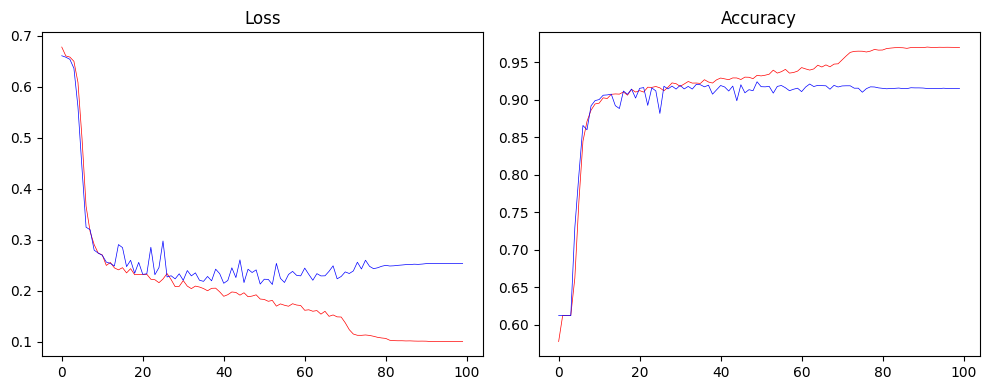

In [25]:
if __name__ == "__main__":
    model=create_model(x_train.shape[1:])
    # compile
    model.compile(loss={'outputs': 'binary_crossentropy','rri':'mean_squared_error','ampl':'mean_squared_error'},loss_weights={
                  'outputs': 1,'rri': 1,'ampl':1}, optimizer='adam', metrics={'outputs':'accuracy'})
    filepath='/content/drive/MyDrive/Final Result/Final_performance/BAFNet/model/min_mean_1.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_outputs_accuracy', verbose=1, save_best_only=True,mode='max')
    lr_scheduler = LearningRateScheduler(lr_schedule)
    callbacks_list = [lr_scheduler, checkpoint]
    time_begin = time.time()
    history = model.fit(x_train, [y_train,ampl_train,rri_train], batch_size=128, epochs=100,
                        validation_data=(x_val, [y_val,ampl_val,rri_val]),callbacks=callbacks_list)
    time_end = time.time()
    t = time_end - time_begin
    print('time_train:', t)
    plot(history.history)

#     test
#     model= load_model(filepath,custom_objects={'ScaledDotProductAttention':ScaledDotProductAttention})

    r= model.evaluate(x_test, [y_test,ampl_test,rri_test])
    loss=r[0]
    acc=r[-1]
    # save prediction score
    y_score = model.predict(x_test, batch_size=1024, verbose=1)[0]
    roc=roc_auc_score(y_score=y_score,y_true=y_test)
    output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
# Export to csv file
    output.to_csv("/content/drive/MyDrive/Final Result/Final_performance/BAFNet/file_name.csv", index=False)
    y=model.predict(x_test, batch_size=1024, verbose=1)[0]
    y_true, y_pred = np.argmax(y_test, axis=-1), np.argmax(y, axis=-1)
    C = confusion_matrix(y_true, y_pred, labels=(1, 0))
    TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
    acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
    f1=f1_score(y_true, y_pred, average='binary')

    print("TP:{}, TN:{}, FP:{}, FN:{}, loss{}, acc{}, sn{}, sp{}, f1{}, roc{}".format(TP, TN, FP, FN,loss, acc, sn, sp, f1, roc))